# HPR

In [1]:
import matplotlib.pyplot as mpl 
%matplotlib inline
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd
import pylab

In [2]:
'''
Generate fake data in the paper
'''
def generateData(nObs,size0,size1,sigma1): 
    '''
    nObs: # of observations (time series)
    size0: # of uncorrelated assets
    size1: # of correlated assets
    sigma1: # sigma of deviation that will be added to the uncorrelated data
    ==================================================================================
    First 5 cols are assumed to be uncorrelated, generated by #1); 
    last 5 cols are correlated, generated by #2). Specifically, using the first 5 plus some deviation: N(0,0.25)
    '''
    # Time series of correlated variables 
    #1) generating some uncorrelated data 
    np.random.seed(seed=12345)
    random.seed(12345)
    x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #2) creating correlation between the variables 
    cols=[random.randint(0,size0-1) for i in range(size1)]
    y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols))) 
    x=np.append(x,y,axis=1) 
    x=pd.DataFrame(x,columns=range(1,x.shape[1]+1)) 
    return x,cols

In [3]:
'''
Plot corMatrix heat map
'''
def plotCorrMatrix(corr,labels=None,path=None): 
    # Heatmap of the correlation matrix 
    if labels is None:
        labels=[] 
    mpl.pcolor(corr,cmap='jet') 
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels) 
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels) 
    if path!=None:
        mpl.savefig(path) 
        mpl.clf();
        mpl.close() # reset pylab return
    else:
        mpl.plot()

In [4]:
'''
Distance calculator, returns matrix D in Hudson and Thames' website
'''
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist

In [6]:
'''
Use getQuasiDiag for section/step 2. Input is a distance matrix.
'''
def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] # number of original items
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2
        sortIx=sortIx.sort_index() # re-sort
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

#### getIVP formula:
$\frac{1}{tr[\text{diag}[V_i^{(j)}]^{(-1)}]}$

In [7]:
'''
See inverse-variance weighting, Wikipedia
'''
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    
    return cVar

In [8]:
def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster

    while len(cItems)>0:
        _temp = []
        for i in cItems:
            for j,k in ((0,len(i)//2),(len(i)//2,len(i))):

                if len(i) > 1:
                        _temp.append(i[j:k])
        cItems=_temp

        for i in range(0,len(cItems),2): # parse in pairs
            cItems0=cItems[i] # cluster 1
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2

    return w

## 1) Generate correlated data

In [9]:
'''
tuple description: 
Ex. (4,6) <=> 6th column is generated by the 4th by adding some deviation to the 4th
'''
nObs,size0,size1,sigma1=10000,5,5,.25 
x,cols=generateData(nObs,size0,size1,sigma1) 
print([(j+1,size0+i) for i,j in enumerate(cols,1)])

[(4, 6), (1, 7), (3, 8), (3, 9), (2, 10)]


In [10]:
# file_path = "asset_class_daily.csv"
# df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# def cum_prod(array):
#     return np.prod(array + 1) - 1

# # adjust the data into monthly returns 
# df = df.resample('M').apply(cum_prod)

# df_tilde = df.apply(lambda x: x - df['Cash'],axis=0)
# df_tilde.drop(columns=['Cash'], inplace=True)
# df_tilde.head()

# x = df_tilde

## 2) Compute and plot correl matrix

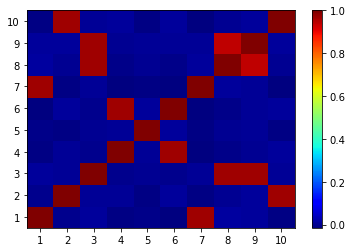

In [11]:
'''
Notice that there is a tiny difference between 
the chart in the paper and here - random.seed() is not stable across Python versions
'''
cov,corr=x.cov(),x.corr() 
# plotCorrMatrix(corr,labels=corr.columns,'HRP3_corr0.png')
plotCorrMatrix(corr,labels=corr.columns)

## 3 Cluster
#### Using Z-standardized matrix instead of d

<ipython-input-12-3bc7cc96d6f5>:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(distMat,'single') ## Return a new order of corr index


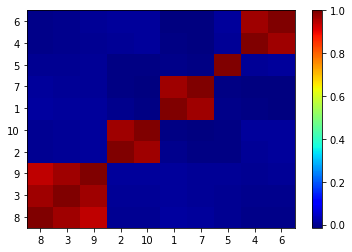

In [12]:
stdcorr = corr.copy()

for x in range(10):
    for y in range(10):
        stdcorr.iloc[x,y] = (corr.iloc[x,y]-corr.iloc[:,y].mean())/corr.iloc[:,y].std()

distMat = stdcorr.copy()
for x in range(10):
    for y in range(10):
        distMat.iloc[x,y]=np.sqrt(np.array(list((map(lambda d1,d2:(d1-d2)**2, 
                                                     stdcorr.iloc[:,x], stdcorr.iloc[:,y])))).sum())

link=sch.linkage(distMat,'single') ## Return a new order of corr index 
sortIx=getQuasiDiag(link)
sortIx=corr.index[sortIx].tolist() # recover labels ## i.e., sortIx + 1
df0=corr.loc[sortIx,sortIx] # reorder
plotCorrMatrix(df0,labels=df0.columns)

#### Don't use Z-standardization at all, directly compute distance matrix using raw correlation matrix

<ipython-input-13-686fd709deb0>:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(rawDistMat,'single') ## Return a new order of corr index


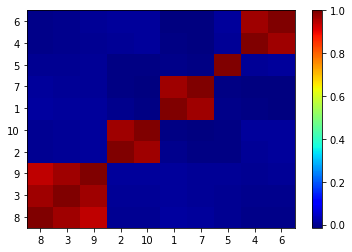

In [13]:
rawDistMat = stdcorr.copy()
for x in range(10):
    for y in range(10):
        rawDistMat.iloc[x,y]=np.sqrt(np.array(list((map(lambda d1,d2:(d1-d2)**2, 
                                                     stdcorr.iloc[:,x], stdcorr.iloc[:,y])))).sum())

link=sch.linkage(rawDistMat,'single') ## Return a new order of corr index 
sortIx=getQuasiDiag(link)
sortIx=corr.index[sortIx].tolist() # recover labels ## i.e., sortIx + 1

df0=corr.loc[sortIx,sortIx] # reorder
plotCorrMatrix(df0,labels=df0.columns)

#### Use d from paper

[8, 3, 9, 2, 10, 1, 7, 5, 4, 6]


<ipython-input-15-28d9bd57c18d>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist,'single') ## Return a new order of corr index


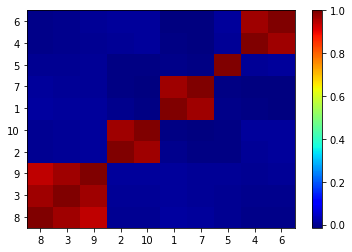

In [15]:
dist=correlDist(corr)
link=sch.linkage(dist,'single') ## Return a new order of corr index 
sortIx=getQuasiDiag(link)

sortIx=corr.index[sortIx].tolist() # recover labels ## i.e., sortIx + 1
print(sortIx)
df0=corr.loc[sortIx,sortIx] # reorder

plotCorrMatrix(df0,labels=df0.columns)


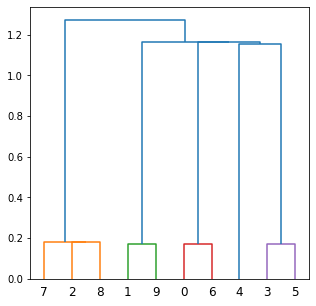

In [21]:
from scipy.cluster.hierarchy import dendrogram
fig = mpl.figure(figsize=(5, 5))

dn = dendrogram(link)
mpl.show()

## 4) Asset allocation

In [15]:
hrp=getRecBipart(cov,sortIx)
hrp

8     0.071408
3     0.075961
9     0.125317
2     0.067596
10    0.063236
1     0.109945
7     0.103968
5     0.193357
4     0.097549
6     0.091662
dtype: float64

In [30]:
list_ = [1,3,5,2,2,4,1,2,3,1,2,4,1]

for i in range(2):
    list_ =  np.array_split(list_,3)

print(*list_)

[array([1, 3, 5, 2, 2])] [array([4, 1, 2, 3])] [array([1, 2, 4, 1])]


C:\Users\liuyi\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [38]:
print(np.ceil(6*0.3))
np.quantile([1, 2, 3, 4, 5, 6,],0.3)

2.0


2.5

In [44]:
a = np.array([1,2,3])
a = np.append(np.append(a,[4,5]),5)
a

array([1, 2, 3, 4, 5, 5])

In [46]:
a = [1,2,3]
a.append([4,5])
a

[1, 2, 3, [4, 5]]